In [29]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [30]:
from graph.structure.graph import Graph
from graph.prior.gaussian_prior import GaussianPrior
from graph.propagator.unitary_propagator import UnitaryPropagator
from graph.measurement.gaussian_measurement import GaussianMeasurement
from core.linalg_utils import random_unitary_matrix
import numpy as np

In [31]:
# === パラメータ設定 ===
n = 64
shape = (n,)
var = 1e-4
rng = np.random.default_rng(123)

U1 = random_unitary_matrix(n, rng=rng)
U2 = random_unitary_matrix(n, rng=rng)

In [32]:
# === グラフ定義 ===
class SplitGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = GaussianPrior(var=1.0, shape=shape)
        self.Y1 = UnitaryPropagator(U1) @ self.X
        self.Z1 = GaussianMeasurement(var=var) @ self.Y1
        self.Y2 = UnitaryPropagator(U2) @ self.X
        self.Z2 = GaussianMeasurement( var=var) @ self.Y2
        self.compile()

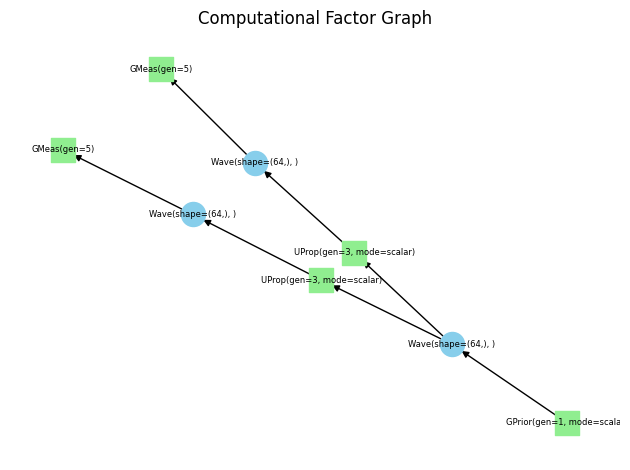

In [33]:
g = SplitGraph()
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)

In [34]:
g.set_init_rng(np.random.default_rng(1))
g.generate_sample(rng=np.random.default_rng(9))

true_x = g.X.get_sample()
g.Z1.update_observed_from_sample()
g.Z2.update_observed_from_sample()

In [35]:
def monitor(graph, t):
    if t % 10 == 0:
        est = graph.X.compute_belief().data
        err = np.mean(np.abs(est - true_x)**2)
        print(f"[t={t}] MSE = {err:.3e}")

g.run(n_iter=50, callback=monitor)

BP Iteration: 100%|██████████| 50/50 [00:00<00:00, 1912.22it/s]

[t=0] MSE = 8.898e-05
[t=10] MSE = 8.895e-05
[t=20] MSE = 8.895e-05
[t=30] MSE = 8.895e-05
[t=40] MSE = 8.895e-05


In [36]:
g.X.precision_mode

'scalar'

## Coded Diffraction Pattern

In [37]:
import numpy as np
from core.metrics import pmse
from core.linalg_utils import random_phase_mask
from graph.structure.graph import Graph
from graph.prior.gaussian_prior import GaussianPrior
from graph.propagator.phase_mask_propagator import PhaseMaskPropagator
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

H, W = 128, 128
shape = (H, W)
var = 1e-4
rng = np.random.default_rng(seed=42)

class CDPGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = GaussianPrior(var=1.0, shape=shape, label = "object")

        # Measurement を self に明示的に保持
        self.Z_list = []
        for i in range(4):
            phase = random_phase_mask(shape, rng=rng)
            Y = PhaseMaskPropagator(phase) @ self.X
            F = FFT2DPropagator(shape=shape) @ Y
            Z = AmplitudeMeasurement(var=var, damping=0.3) @ F
            setattr(self, f"Z{i+1}", Z)  # self.Z1, self.Z2, ... に登録
            self.Z_list.append(Z)

        self.compile()

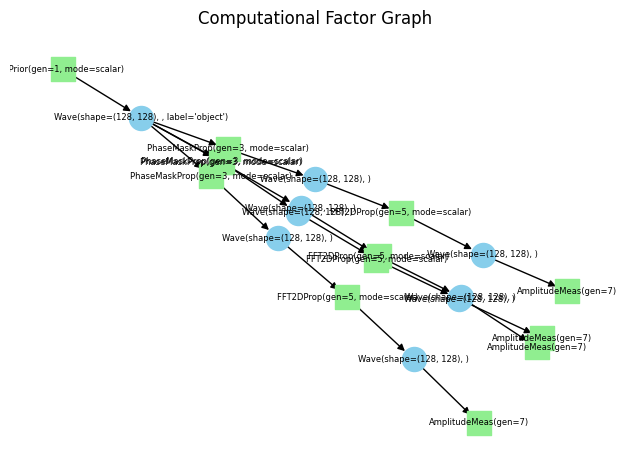

In [38]:
g = CDPGraph()
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)

In [39]:
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)
true_x = g.X.get_sample()

In [40]:
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = pmse(est, true_x)
    if t % 20 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=200, callback=monitor)

BP Iteration:  17%|█▋        | 34/200 [00:00<00:00, 169.19it/s]

[t=0] PMSE = 2.23664e+00
[t=20] PMSE = 2.52627e+00


BP Iteration:  36%|███▌      | 71/200 [00:00<00:00, 174.92it/s]

[t=40] PMSE = 1.34143e-01
[t=60] PMSE = 3.08151e-04


BP Iteration:  54%|█████▍    | 108/200 [00:00<00:00, 176.10it/s]

[t=80] PMSE = 1.53026e-04
[t=100] PMSE = 1.52697e-04


BP Iteration:  73%|███████▎  | 146/200 [00:00<00:00, 179.57it/s]

[t=120] PMSE = 1.52697e-04
[t=140] PMSE = 1.52697e-04


BP Iteration:  92%|█████████▏| 183/200 [00:01<00:00, 178.53it/s]

[t=160] PMSE = 1.52697e-04
[t=180] PMSE = 1.52697e-04


BP Iteration: 100%|██████████| 200/200 [00:01<00:00, 176.99it/s]


In [41]:
%prun -l 40 -s cumulative g.run(n_iter=200, callback=monitor)

BP Iteration:  18%|█▊        | 36/200 [00:00<00:00, 173.04it/s]

[t=0] PMSE = 1.52697e-04
[t=20] PMSE = 1.52697e-04


BP Iteration:  27%|██▋       | 54/200 [00:00<00:00, 170.81it/s]

[t=40] PMSE = 1.52697e-04
[t=60] PMSE = 1.52697e-04


BP Iteration:  54%|█████▍    | 108/200 [00:00<00:00, 173.88it/s]

[t=80] PMSE = 1.52697e-04
[t=100] PMSE = 1.52697e-04


BP Iteration:  73%|███████▎  | 146/200 [00:00<00:00, 165.17it/s]

[t=120] PMSE = 1.52697e-04
[t=140] PMSE = 1.52697e-04


BP Iteration:  90%|█████████ | 180/200 [00:01<00:00, 162.96it/s]

[t=160] PMSE = 1.52697e-04
[t=180] PMSE = 1.52697e-04


BP Iteration: 100%|██████████| 200/200 [00:01<00:00, 164.84it/s]

         292153 function calls in 1.215 seconds

   Ordered by: cumulative time
   List reduced from 236 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.215    1.215 {built-in method builtins.exec}
        1    0.000    0.000    1.215    1.215 <string>:1(<module>)
        1    0.001    0.001    1.215    1.215 graph.py:136(run)
      200    0.002    0.000    0.851    0.004 graph.py:131(backward)
      800    0.002    0.000    0.432    0.001 fft_2d_propagator.py:104(backward)
      800    0.044    0.000    0.367    0.000 fft_2d_propagator.py:55(compute_belief)
      800    0.001    0.000    0.260    0.000 base.py:129(backward)
      800    0.003    0.000    0.250    0.000 amplitude_measurement.py:84(_compute_message)
      200    0.002    0.000    0.246    0.001 graph.py:126(forward)
     1600    0.005    0.000    0.242    0.000 _pocketfft.py:701(_raw_fftnd)
     3200    0.224    0.000    0.232    0.0